In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import re
import nltk
!pip install gensim
!pip install numpy==1.26.4 --force-reinstall

import gensim.downloader as api
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:

# Load dataset
print("Loading dataset...")
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']).rename(columns={'v1': 'category', 'v2': 'message'})


Loading dataset...


In [ ]:

# Check and remove null/duplicate values
print("Null values before drop:")
print(df.isnull().sum())
df = df.dropna().drop_duplicates()
print("Null values after drop:")
print(df.isnull().sum())


Null values before drop:
category    0
message     0
dtype: int64
Null values after drop:
category    0
message     0
dtype: int64


In [ ]:

# Text preprocessing
# df['message'] = df['message'].str.lower()
# df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
# stop_words = set(stopwords.words('english'))
# df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
# df['message'] = df['message'].apply(word_tokenize)
# lemmatizer = WordNetLemmatizer()
# df['message'] = df['message'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
# df['category'] = df['category'].map({'spam': 1, 'ham': 0})


In [ ]:
from nltk.stem import PorterStemmer
!pip install emoji
import emoji

stemmer = PorterStemmer()

# Text preprocessing
df['message'] = df['message'].str.lower()
df['message'] = df['message'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df['message'] = df['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df['message'] = df['message'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and len(word) > 2 and word.isalpha()]))
df['message'] = df['message'].apply(word_tokenize)
lemmatizer = WordNetLemmatizer()
df['message'] = df['message'].apply(lambda x: ' '.join([stemmer.stem(lemmatizer.lemmatize(word)) for word in x]))
df['category'] = df['category'].map({'spam': 1, 'ham': 0})

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


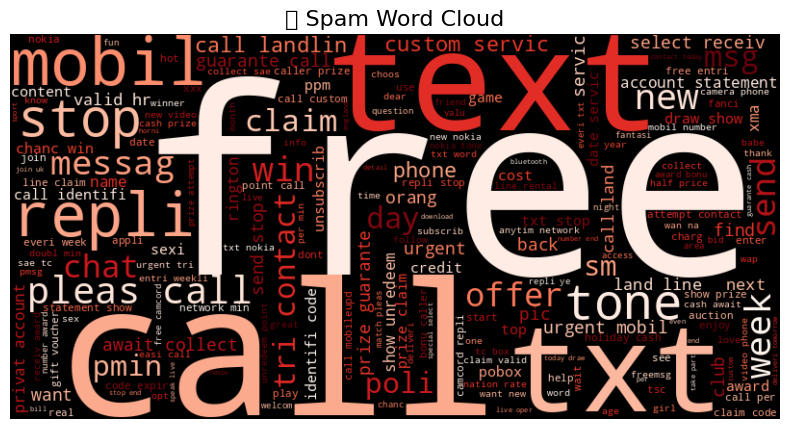

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


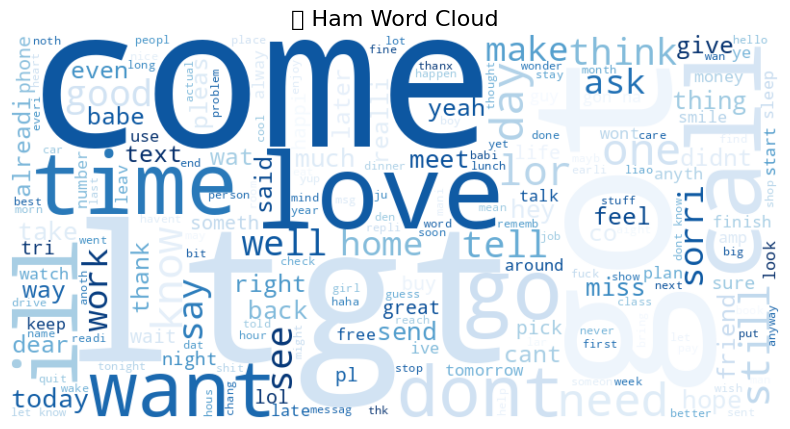

In [27]:
!pip install wordcloud
from wordcloud import WordCloud
# Word Clouds for Spam and Ham
spam_text = ' '.join(df[df['category'] == 1]['message'])
ham_text = ' '.join(df[df['category'] == 0]['message'])

spam_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_text)
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("\U0001F6AB Spam Word Cloud", fontsize=16)
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("\u2705 Ham Word Cloud", fontsize=16)
plt.show()

In [ ]:

# Load GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-100")

def get_glove_embeddings(texts):
    embeddings = []
    for text in texts:
        words = text.split()
        word_vectors = [glove_model[word] for word in words if word in glove_model]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(100))
    return np.array(embeddings)

X = get_glove_embeddings(df['message'])
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Logistic Regression Results
Training Accuracy: 93.37%
Testing Accuracy: 92.55%
Accuracy: 92.55%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       889
           1       0.77      0.66      0.71       145

    accuracy                           0.93      1034
   macro avg       0.86      0.82      0.84      1034
weighted avg       0.92      0.93      0.92      1034

Precision: 0.77, Recall: 0.66, F1: 0.71, AUC: 0.96
Confusion Matrix:
[[861  28]
 [ 49  96]]


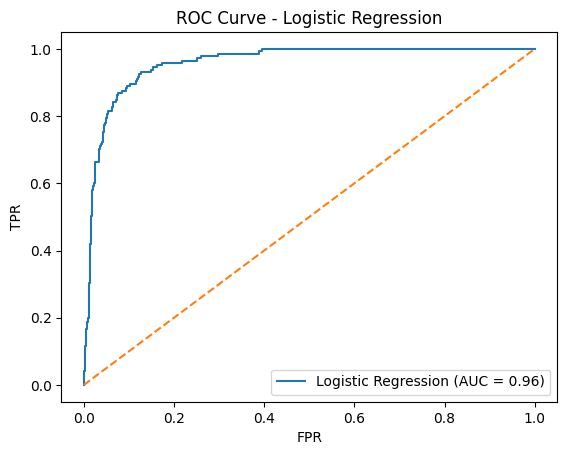

In [ ]:

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]
print("\nLogistic Regression Results")
print(f"Training Accuracy: {accuracy_score(y_train, model_lr.predict(X_train)) * 100:.2f}%")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_lr) * 100:.2f}%")
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_lr))
print(f"Precision: {precision_score(y_test, y_pred_lr):.2f}, Recall: {recall_score(y_test, y_pred_lr):.2f}, F1: {f1_score(y_test, y_pred_lr):.2f}, AUC: {auc(*roc_curve(y_test, y_prob_lr)[:2]):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()




Random Forest Results
Training Accuracy: 99.93%
Testing Accuracy: 94.39%
Accuracy: 94.39%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       889
           1       0.98      0.61      0.75       145

    accuracy                           0.94      1034
   macro avg       0.96      0.81      0.86      1034
weighted avg       0.95      0.94      0.94      1034

Precision: 0.98, Recall: 0.61, F1: 0.75, AUC: 0.97
Confusion Matrix:
[[887   2]
 [ 56  89]]


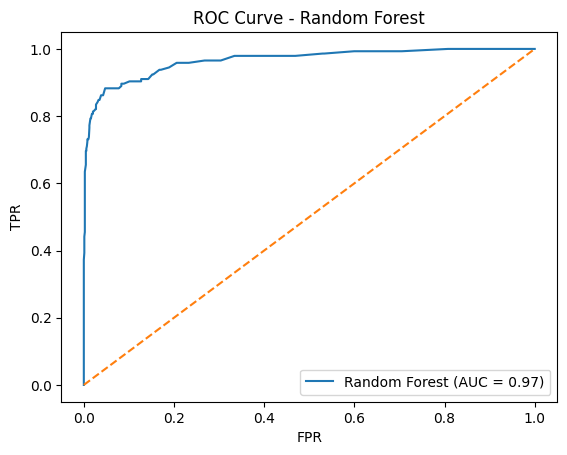

In [ ]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]
print("\nRandom Forest Results")
print(f"Training Accuracy: {accuracy_score(y_train, model_rf.predict(X_train)) * 100:.2f}%")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_rf))
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}, Recall: {recall_score(y_test, y_pred_rf):.2f}, F1: {f1_score(y_test, y_pred_rf):.2f}, AUC: {auc(*roc_curve(y_test, y_prob_rf)[:2]):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()




SVM Results
Training Accuracy: 97.00%
Testing Accuracy: 95.94%
Accuracy: 94.39%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       889
           1       0.91      0.79      0.85       145

    accuracy                           0.96      1034
   macro avg       0.94      0.89      0.91      1034
weighted avg       0.96      0.96      0.96      1034

Precision: 0.91, Recall: 0.79, F1: 0.85, AUC: 0.98
Confusion Matrix:
[[877  12]
 [ 30 115]]


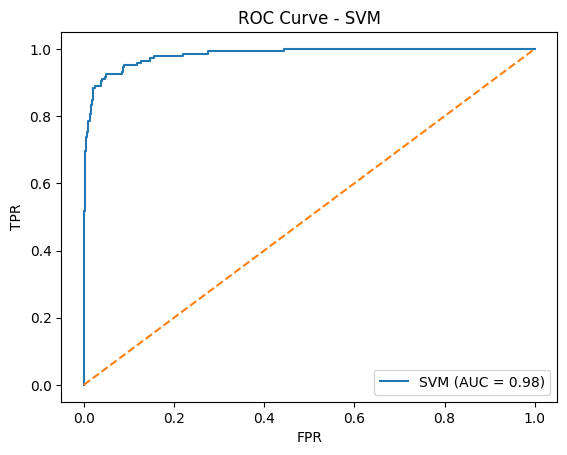

In [ ]:
# SVM
model_svm = SVC(probability=True)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)
y_prob_svm = model_svm.predict_proba(X_test)[:, 1]
print("\nSVM Results")
print(f"Training Accuracy: {accuracy_score(y_train, model_svm.predict(X_train)) * 100:.2f}%")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%")
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_svm))
print(f"Precision: {precision_score(y_test, y_pred_svm):.2f}, Recall: {recall_score(y_test, y_pred_svm):.2f}, F1: {f1_score(y_test, y_pred_svm):.2f}, AUC: {auc(*roc_curve(y_test, y_prob_svm)[:2]):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve - SVM")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.8376 - loss: 0.5121 - val_accuracy: 0.8598 - val_loss: 0.4046
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.8784 - loss: 0.3828 - val_accuracy: 0.8598 - val_loss: 0.4034
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.8727 - loss: 0.3919 - val_accuracy: 0.8598 - val_loss: 0.4012
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.8770 - loss: 0.3814 - val_accuracy: 0.8598 - val_loss: 0.3962
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.8810 - loss: 0.3593 - val_accuracy: 0.8598 - val_loss: 0.3804
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8707 - loss: 0.3622
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8505 - loss: 0.3957
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

LSTM Results
Training Accuracy: 87.71%
Testing Accuracy: 85.98%
Accuracy: 85.98%
              precision    recall  f1-score   support

           0       0.86      1.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

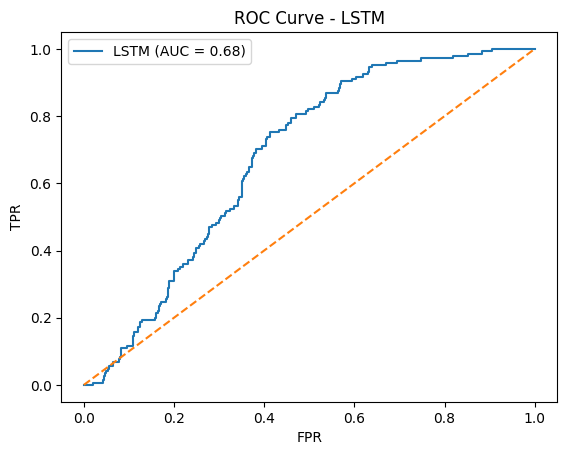

In [ ]:
# LSTM
model_lstm = Sequential([
    Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

train_loss, train_accuracy = model_lstm.evaluate(X_train, y_train)
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)
y_prob_lstm = model_lstm.predict(X_test).flatten()
y_pred_lstm = (y_prob_lstm > 0.5).astype("int32")
print("\nLSTM Results")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_lstm))
print(f"Precision: {precision_score(y_test, y_pred_lstm):.2f}, Recall: {recall_score(y_test, y_pred_lstm):.2f}, F1: {f1_score(y_test, y_pred_lstm):.2f}, AUC: {auc(*roc_curve(y_test, y_prob_lstm)[:2]):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))
fpr, tpr, _ = roc_curve(y_test, y_prob_lstm)
plt.plot(fpr, tpr, label=f"LSTM (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve - LSTM")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()